# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Actividad 2.1 - Detección de carriles en video usando transformada de Hough**
____

**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez 
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson 
*   Fernando Sebastian Sanchez Cardona 

____

# Importar librerias necesarias

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

from IPython.display import clear_output
from IPython.display import display
from ipywidgets import Video, Image

# Ajuste de parámetros: Paso a paso

## Cargar video

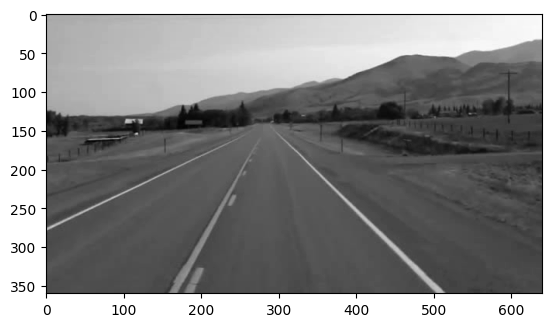

In [2]:
# Graficamos el primer frame del video como una prueba de que el archivo fue leido correctamente
video_file = 'input/test2_low-res.mp4'
#video_file = 'input/test2.mp4'
cap = cv2.VideoCapture(video_file)

while cap.isOpened():
    ret, image_fr1 = cap.read()

    if not ret:
        break

    img_grey_fr1 = cv2.cvtColor(image_fr1, cv2.COLOR_BGR2GRAY) # Convertir la imagen a escala de grises
    img_rgb_fr1 = cv2.cvtColor(image_fr1, cv2.COLOR_BGR2RGB)
    plt.imshow(img_grey_fr1, cmap='gray')
    cap.release() # Libera el video y cumple como condicion de escape del ciclo while

## Detectar bordes en las imagenes

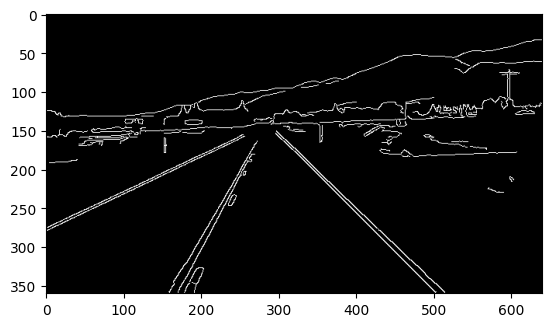

In [3]:
img_blur = cv2.GaussianBlur(img_grey_fr1,(3,3), 0, 0)
img_canny = cv2.Canny(img_blur, 40, 120) 
plt.imshow(img_canny, cmap='gray');

## Obtener medidas del video

In [4]:
img_arr = np.asarray(img_grey_fr1)
print(f'Alto: {img_arr.shape[0]} px, ancho: {img_arr.shape[1]} px.')

Alto: 360 px, ancho: 640 px.


## Definir area de interés y revisar bordes dentro del ROI

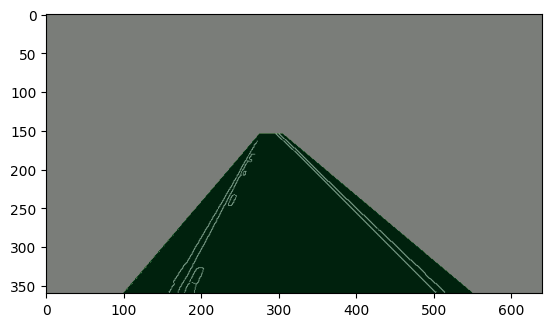

In [5]:
# ROI arbitraria
#vertices = np.array([[(200,720),(550, 310), (610, 310), (1100,720)]], dtype=np.int32)
vertices = np.array([[(100,360),(275, 155), (305, 155), (550,360)]], dtype=np.int32)
# imagen en negro de las mismas dimensiones que la imagen original en escala de grises
img_roi = np.zeros_like(img_grey_fr1)
# la ROI se pinta de blanco sobre la imagen en negro
cv2.fillPoly(img_roi, vertices, 255)

img_mask = cv2.bitwise_and(img_canny, img_roi)

plt.imshow(img_mask, cmap='gray')
plt.imshow(img_roi, cmap='Greens', alpha=0.5);

##### Resaltar lineas encontradas en el ROI

Para resaltar las caracteristicas de las lineas dentro del ROI, utilizamos la transformada de Hough para lineas

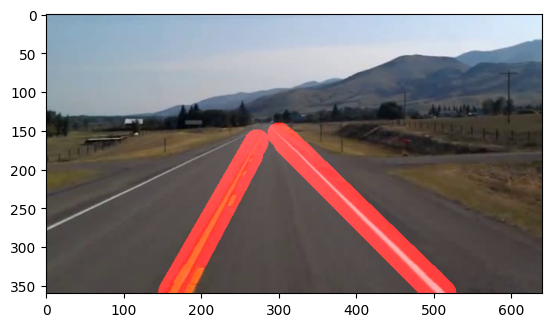

In [6]:
rho = 1           # resolución de rho en pixeles
theta = np.pi/180  # resolución de theta en radianes 
threshold = 70     # mínimo número de votos para ser considerado una línea 
min_line_len = 20  # mínimo número de pixeles para que se forme una línea
max_line_gap = 70  # máximo espacio en pixeles entre segmentos de línea    
lines = cv2.HoughLinesP(img_mask, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
# se crea un fondo negro del tamaño de la imagen con bordes
img_lines = np.zeros((img_mask.shape[0], img_mask.shape[1], 3), dtype=np.uint8)
# se dibujan cada una de las líneas sobre la imagen con fondo negro    
for line in lines:
    for x1,y1,x2,y2 in line:      
        cv2.line(img_lines, (x1, y1), (x2, y2), [255, 0, 0], 30)
        

alpha = 1
beta = 1
gamma = 1
img_lane_lines = cv2.addWeighted(img_rgb_fr1, alpha, img_lines, beta, gamma)
plt.imshow(img_lane_lines);

# Integración en una función

En esta función se realiza el seguiminto de las líneas detectadas en cada frame del video

In [7]:
def genera_img_hough_lines(
  img_mask,
  rho = 2,            # resolución de rho en pixeles
  theta = np.pi/180,  # resolución de theta en radianes 
  threshold = 70,     # mínimo número de votos para ser considerado una línea 
  min_line_len = 20,  # mínimo número de pixeles para que se forme una línea
  max_line_gap = 120,  # máximo espacio en pixeles entre segmentos de línea    
):
    
    lines = cv2.HoughLinesP(img_mask, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # se crea un fondo negro del tamaño de la imagen con bordes
    img_lines = np.zeros((img_mask.shape[0], img_mask.shape[1], 3), dtype=np.uint8)
    # se dibujan cada una de las líneas sobre la imagen con fondo negro    
    for line in lines:
        for x1,y1,x2,y2 in line:      
            cv2.line(img_lines, (x1, y1), (x2, y2), [255, 0, 0], 30)

    # se retorna la imagen generada
    return img_lines

## Implementación de la función

In [11]:
cap = cv2.VideoCapture(video_file)

frames = []

while(1):
    try:
        ret, image = cap.read()
        
        # Convertir la imagen a escala de grises
        img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #vertices = np.array([[(200,720),(550, 310), (610, 310), (1100,720)]], dtype=np.int32)
        vertices = np.array([[(100,360),(275, 155), (305, 155), (550,360)]], dtype=np.int32)
        img_roi = np.zeros_like(img_grey_fr1)
        cv2.fillPoly(img_roi, vertices, 255)
        
        img_blur = cv2.GaussianBlur(img_grey,(3,3), 0, 0)
        img_canny = cv2.Canny(img_blur, 40, 120) 
        img_mask = cv2.bitwise_and(img_canny, img_roi)

        # imagen generada a partir de las lineas encontradas usando la transformada de Hough
        img_lines = genera_img_hough_lines(img_mask)

        alpha = 1
        beta = 1
        gamma = 1
        img_lane_lines = cv2.addWeighted(img_rgb, alpha, img_lines, beta, gamma)
        img_lane_lines = cv2.cvtColor(img_lane_lines, cv2.COLOR_RGB2BGR)

        frames.append(img_lane_lines)
    except Exception:
        break

#Establecer parámetros para guardar el video procesado
width = int(cap.get(3))
height = int(cap.get(4))

filename = 'output/test2_detect.mp4'

fourcc = cv2.VideoWriter_fourcc(*'avc1')
writer = cv2.VideoWriter(filename, fourcc, 25, (width, height))

#Escribir cuadro por cuadro
for frame in frames:
    writer.write(frame)

cap.release()
writer.release()

## Revisión del video 

In [12]:
video2 = Video.from_file(filename)
video2

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1d7\xa8mdat\x00\x…